In [189]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
from scipy.signal import find_peaks


In [190]:
logFilePath = "../../logs"
red_adc_min_sample_threshold = 30000

In [191]:
def findLatestLogFile():
    list_of_files = glob.glob(os.path.join(logFilePath, '*.log'))
    latest_file = max(list_of_files, key=os.path.getctime)
    return latest_file

In [192]:
def readHRMData(logfile):
    # Each line is formatted like this:
    # I (47510) MAX30101: service i2cAddr 0x57 sampleRate 12.5/s numSamples 7 writePtr 28 readPtr 21 samples 32159 32013 32056 32108 32164 32219 32519 

    # Log data
    timestamps = []
    red_led_adc_values = []
    first_sample_line_time_ms = 0

    # Read the file
    with open(logfile) as f:
        lines = f.readlines()

        # Iterate over each line
        for line in lines:

            # Validate line contains samples
            if "samples" not in line:
                continue

            # Split the line into words
            words = line.split()

            # Extract the timestamp (in brackets and microseconds)
            line_time_ms = int(words[1][1:-1])

            # Find the sampleRate field
            sample_rate_index = words.index("sampleRate")
            sample_rate = float(words[sample_rate_index + 1][:-2])

            # Find the numSamples field
            num_samples_index = words.index("numSamples")
            num_samples = int(words[num_samples_index + 1])

            # Find the samples field
            samples_index = words.index("samples") + 1

            # Timestamp of first line
            if first_sample_line_time_ms == 0:
                first_sample_line_time_ms = line_time_ms

            # Calculate the time difference
            line_start_ms = line_time_ms - first_sample_line_time_ms

            # Store sample rate and samples
            for i in range(num_samples):
                sample_value = int(words[samples_index + i])
                if sample_value < red_adc_min_sample_threshold:
                    continue
                timestamps.append(line_start_ms + (i / sample_rate) * 1000)
                red_led_adc_values.append(sample_value)

    # Convert to numpy arrays
    timestamps = np.array(timestamps)
    red_led_adc_values = np.array(red_led_adc_values)
    
    return timestamps, red_led_adc_values


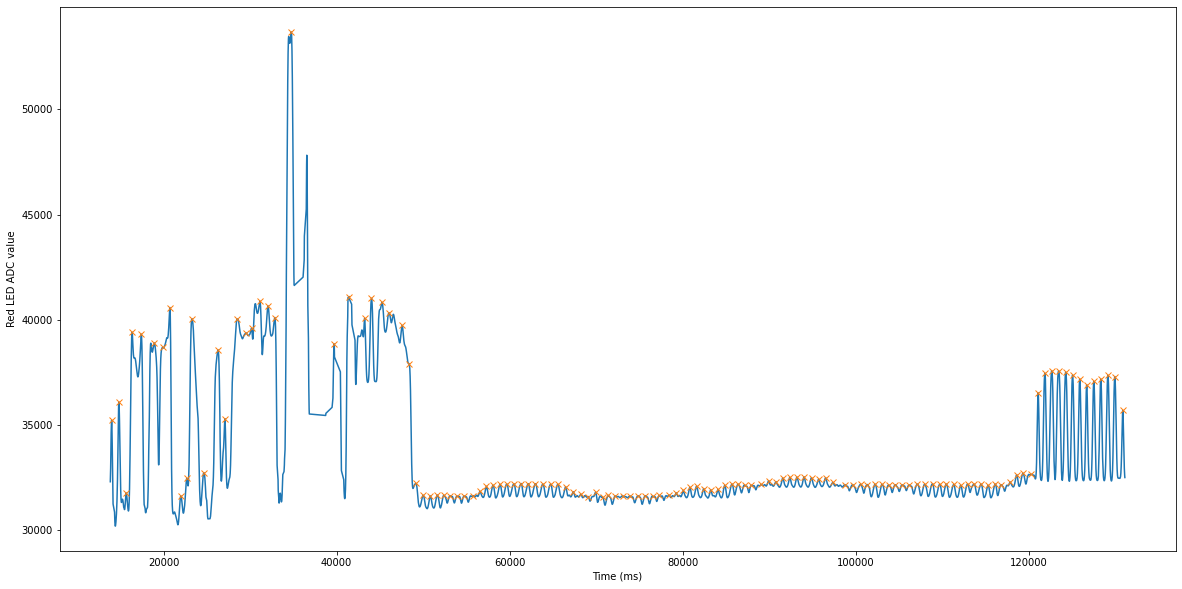

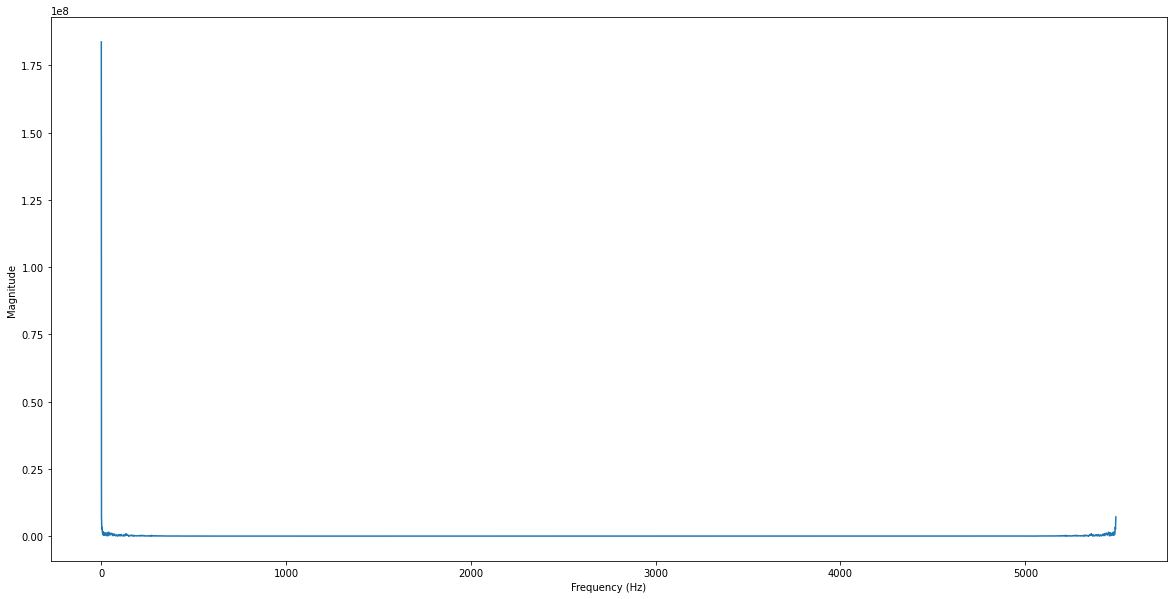

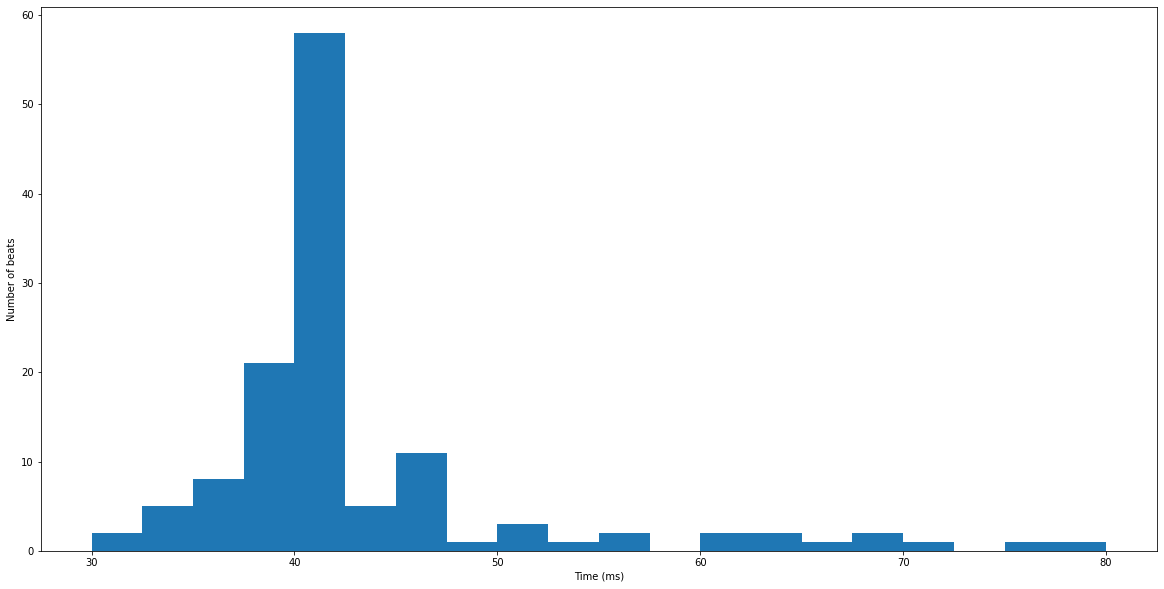

In [193]:
if __name__ == "__main__":

    # Find the latest log file
    logfile = findLatestLogFile()

    # Read the HRM data
    timestamps, red_led_adc_values = readHRMData(logfile)

    # Set plot size
    matplotlib.rcParams['figure.figsize'] = [20, 10]

    # # Plot the data
    # plt.plot(timestamps, red_led_adc_values)
    # plt.xlabel("Time (ms)")
    # plt.ylabel("Red LED ADC value")
    # plt.show()

    # Filter the data using a 2nd order Butterworth filter
    from scipy.signal import butter, filtfilt
    b, a = butter(2, 0.1, 'low')
    red_led_adc_values = filtfilt(b, a, red_led_adc_values)

    # # Plot the filtered data
    # plt.plot(timestamps, red_led_adc_values)
    # plt.xlabel("Time (ms)")
    # plt.ylabel("Red LED ADC value")
    # plt.show()

    # Calculate the heart rate
    peaks, _ = find_peaks(red_led_adc_values, height=100, distance=30)
    peaks = peaks.astype(int)
    peaks = peaks[peaks < len(timestamps)]  # Ensure peaks are within valid range

    # print("Heart rate: ", 60000 / np.mean(np.diff(peaks)), " BPM")

    print(peaks)
    
    # Plot the peaks
    plt.plot(timestamps, red_led_adc_values)
    plt.plot(timestamps[peaks], red_led_adc_values[peaks], "x")
    plt.xlabel("Time (ms)")
    plt.ylabel("Red LED ADC value")
    plt.show()

    # FFT of the signal
    from scipy.fftpack import fft
    fft_result = fft(red_led_adc_values)
    plt.plot(np.abs(fft_result))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.show()

    # Plot the histogram
    plt.hist(np.diff(peaks), bins=20)
    plt.xlabel("Time (ms)")
    plt.ylabel("Number of beats")
    plt.show()


In [209]:
import numpy as np

# def new_peak_trough(data, max_interval=None):
max_interval = None
data = red_led_adc_values
N = len(data)
L = int(np.ceil(N / 2) - 1) if max_interval is None else int(np.ceil(max_interval / 2) - 1)

# Detrend the data
meanval = np.nanmean(data)
data = np.where(np.isnan(data), meanval, data)
data = data - np.mean(data)  # Simple detrending

Mx = np.zeros((N, L), dtype=bool)
Mn = np.zeros((N, L), dtype=bool)

# Produce the local maxima scalogram
for j in range(L):
    k = j
    for i in range(k+2, N-k+1):
        if data[i-1] > data[i-k-1] and data[i-1] > data[i+k-1]:
            Mx[i-1, j] = True
        if data[i-1] < data[i-k-1] and data[i-1] < data[i+k-1]:
            Mn[i-1, j] = True

# Form Y the column-wise count of where Mx is 0, a scale-dependent distribution of
# local maxima. Find d, the scale with the most maxima (== most number
# of zeros in row). Redimension Mx to contain only the first d scales
Y = np.sum(Mx, axis=0)
d = np.argmax(Y)
Mx = Mx[:, :d+1]

# Form Y the column-wise count of where Mn is 0, a scale-dependent distribution of
# local minima. Find d, the scale with the most minima (== most number
# of zeros in row). Redimension Mn to contain only the first d scales
Y = np.sum(Mn, axis=0)
d = np.argmax(Y)
Mn = Mn[:, :d+1]

# Form Zx and Zn the row-wise counts of Mx and Mn's non-zero elements.
# Any row with a zero count contains entirely zeros, thus indicating
# the presence of a peak or trough
Zx = np.sum(~Mx, axis=1)
Zn = np.sum(~Mn, axis=1)

# Find all the zeros in Zx and Zn. The indices of the zero counts
# correspond to the position of peaks and troughs respectively
peaks = np.where(Zx == 0)[0]
troughs = np.where(Zn == 0)[0]

# return {'peaks': peaks, 'troughs': troughs, 'maximagram': Mx, 'minimagram': Mn}

In [207]:
# Use the new peak trough function
new_peaks = new_peak_trough(red_led_adc_values, max_interval=100)

print(new_peaks)
# # Plot the peaks
# plt.plot(timestamps, red_led_adc_values)
# plt.plot(timestamps[new_peaks], red_led_adc_values[new_peaks], "x")
# plt.xlabel("Time (ms)")
# plt.ylabel("Red LED ADC value")
# plt.show()



{'peaks': array([], dtype=int64), 'troughs': array([], dtype=int64), 'maximagram': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'minimagram': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
